In [7]:
# 1) Выполните сохранение монохромного изображения в виде текстового или бинарного файла.
# 2) Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.
# 3) Выполните квантование высокочастотных компонент (прим., количество квантов = 4).
# 4) Сохраните получившийся массив значений в текстовый или бинарный файл в порядке 
# LL, LH, 
# HL, HH 
# вейвлет-преобразования Хафа. 
# Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).
# 5) Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и
#   изображение, полученным после преобразования Хафа и сжатием длин серий.

import numpy as np
import cv2
import matplotlib.pyplot as plt

1. Выполните сохранение монохромного изображения в виде текстового или бинарного файла.

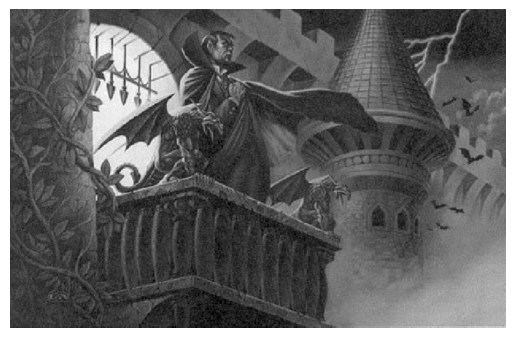

In [8]:
image = cv2.imread('Ravenloft.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.axis('off')
image = image.astype(np.float32)
np.savetxt('Ravenloft.txt', image, fmt="%d")

2. Алгоритм вейвлет-преобразования Хаара для изображения

In [9]:
def HaarWavelet_2D(image):
    rows, cols = image.shape
    temp = np.zeros_like(image, dtype=float)
    hrLen = cols // 2
    for i in range(rows):
        row = image[i, :].copy()
        for j in range(hrLen):
            avgSum  =  (row[2 * j] + row[2 * j + 1]) / np.sqrt(2) # heigh
            avgDiff =  (row[2 * j] - row[2 * j + 1]) / np.sqrt(2) # low
            temp[i, j] = avgSum
            temp[i, j + hrLen] = avgDiff
    result = np.zeros_like(temp)
    hcLen = rows // 2
    for j in range(cols):
        col = image[:, j].copy()
        for i in range(hcLen):
            avgSum  = (col[2 * i] + col[2 * i + 1]) / np.sqrt(2)
            avgDiff = (col[2 * i] - col[2 * i + 1]) / np.sqrt(2)
            result[i, j] = avgSum
            result[i + hcLen, j] = avgDiff
    ll = result[:hcLen, :hrLen]
    hl = result[hcLen:, :hrLen]
    lh = result[:hcLen, hrLen:]
    hh = result[hcLen:, hrLen:]    
    return ll, lh, hl, hh

3. Квантование высокочастотных компонент (количество квантов = 4)

In [ ]:
ll, lh, hl, hh = HaarWavelet_2D(image)
num_levels = 4

def quantize(component, levels=4):
    min_val = np.min(component)
    max_val = np.max(component)
    step = (max_val - min_val) // (levels)
    q = np.round((component - min_val) / step).astype(int)
    return q, min_val, int(step)

lh_quant, lh_min, lh_step = quantize(lh)

hl_quant, hl_min, hl_step = quantize(hl)

hh_quant, hh_min, hh_step = quantize(hh)


def merge_quant_elems(data, level):
    counts = {level: 0 for level in range(level + 1)}
    for value in data.flatten():
        counts[value] += 1
    return counts


lh_merged = merge_quant_elems(lh_quant, num_levels)
hl_merged = merge_quant_elems(hl_quant, num_levels)
hh_merge = merge_quant_elems(hh_quant, num_levels)

4. Сохранение массива в .txt в порядке (LL, LH, HL, HH) вейвлет-преобразования Хафа.
Компоненты LH, HL, HH хранятся в виде пар (значение, количество повторений).

In [11]:
file = open('components.txt', 'w')
np.savetxt(file, ll, fmt='%d')
file.write('\n')
for value, count in lh_merged.items():
    file.write(f"{value * lh_step} {count}\n")
file.write('\n')
for value, count in hl_merged.items():
    file.write(f"{value * hl_step} {count}\n")
file.write('\n')
for value, count in hh_merge.items():
    file.write(f"{value * hh_step} {count}\n")

5. Сравнение объемов памяти исходного изображения и полученного после преобразования Хафа и сжатия длин серий.

In [12]:
original = image.nbytes
with open('components.txt', 'r') as f:
    compressed = len(f.read().encode('utf-8'))

print(f"Размер исходного изображения: {original} Байт")
print(f"Размер сжатого изображения: {compressed} Байт")
print(f"Коэффициент сжатия: {original / compressed:.2f} раз(а)")

Размер исходного изображения: 2203880 Байт
Размер сжатого изображения: 475082 Байт
Коэффициент сжатия: 4.64 раз(а)
